In [1]:
import numpy as np
import pyhf
import json
import cabinetry
from os import listdir, getcwd, path
import requests
from jsonschema import validate
import pruning.normsys_pruning as pruning
#from os.path import isfile, isdir, join

In [2]:
path = getcwd()

In [3]:
names = []

for name in listdir(path):
    if name[-5::] == ".json":
        names.append("/" + name)

names

['/spec_0.035.json',
 '/spec_0.025.json',
 '/spec_0.045.json',
 '/spec_0.075.json',
 '/spec_0.08.json',
 '/bottom-squarks_PA_results.json',
 '/spec_0.07.json',
 '/workspace_Comb.json',
 '/spec_0.09.json',
 '/workspace_1LOS.json',
 '/spec_0.065.json',
 '/spec_0.1.json',
 '/spec_0.095.json',
 '/spec_0.055.json',
 '/bottom-squarks.json',
 '/spec_0.0.json',
 '/spec_0.005.json',
 '/spec_0.06.json',
 '/spec_original.json',
 '/spec_0.05.json',
 '/spec_0.085.json',
 '/spec_0.01.json',
 '/spec_0.03.json',
 '/spec_0.02.json',
 '/spec_0.04.json',
 '/spec_0.015.json']

In [4]:
filename = '/bottom-squarks.json'

In [5]:
workspace_spec = json.load(open(path + filename, 'r'))

workspace = pyhf.Workspace(workspace_spec) 



In [6]:
original_model = workspace.model()
poi_index = original_model.config.poi_index
poi_name = original_model.config.par_names()[poi_index]
poi_name

'mu_SIG'

In [7]:
num_thresholds = 101
pruning_thresholds = [round(float(eps), 3) for eps in np.linspace(0.0, 0.1, num_thresholds)][::5] 
pruning_thresholds

[0.0,
 0.005,
 0.01,
 0.015,
 0.02,
 0.025,
 0.03,
 0.035,
 0.04,
 0.045,
 0.05,
 0.055,
 0.06,
 0.065,
 0.07,
 0.075,
 0.08,
 0.085,
 0.09,
 0.095,
 0.1]

In [8]:
num_thresholds = len(pruning_thresholds)
num_thresholds

21

In [9]:
pruned_workspaces_specs = [ pruning.prune_model(workspace_spec, eps) for eps in pruning_thresholds ]

pruning.prune_model(workspace_spec, 0.0)

output_file = open(path + "/spec_original.json", "w")
json.dump(workspace_spec, output_file, indent=4)
output_file.close()

In [10]:
for l in range(num_thresholds):
    output_file = open(path + "/spec_{}.json".format(pruning_thresholds[l]), "w")
    json.dump(pruned_workspaces_specs[l], output_file, indent=4)
    output_file.close()

In [11]:
pruned_workspaces = [ pyhf.Workspace(workspace_spec) for workspace_spec in pruned_workspaces_specs ]

In [12]:
pruned_models = [ pruned_workspace.model() for pruned_workspace in pruned_workspaces ]

In [13]:
import time

num_executions = 10

In [14]:
pyhf.set_backend("numpy", "minuit")

In [15]:
pyhf.get_backend()

(<pyhf.tensor.numpy_backend.numpy_backend at 0x7fc5dc7aee80>,
 <pyhf.optimize.minuit_optimizer at 0x7fc5dc74ab20>)

In [16]:
%time
average_exec_times = []
exec_times = []
output_params_all_specs = []

for l in range(num_thresholds):
    
    pruned_data = pruned_workspaces[l].data(pruned_models[l]) #, include_auxdata=False)

    exec_times_pruned = []
    output_params_sigle_spec = []

    for k in range(num_executions):
        t0 = time.time()
        output_params = pyhf.infer.mle.fit(data=pruned_data, pdf=pruned_models[l])
        t1 = time.time()
        exec_times_pruned.append(t1-t0)
        
        output_params_sigle_spec.append(dict(zip(pruned_models[l].config.par_names(), output_params)))
        print(k+1)
        print(output_params)
        
    print("eps = {} ----------------------------".format(pruning_thresholds[l]))
    
    exec_times.append(exec_times_pruned)
    
    exec_times_pruned = np.array(exec_times_pruned)
    
    average_exec_times.append(float(np.mean(exec_times_pruned)))
    
    output_params_all_specs.append(output_params_sigle_spec)
    

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 30.8 µs
1
[ 9.99979738e-01  9.99027998e-01  6.62764299e-05  7.41803920e-05
 -1.31715649e-03 -5.53842414e-02 -7.42011570e-02 -6.32418871e-03
 -1.31715650e-03 -5.01928222e-03 -4.83300048e-03  9.02938927e-03
  3.68976045e-04  1.41909605e-02  2.07695721e-02 -5.15841088e-03
 -1.31715656e-03 -1.31715655e-03 -2.60817900e-03 -7.70732692e-03
 -3.42090156e-03 -1.24003918e-02 -2.19085151e-03 -1.69571592e-03
 -3.20220633e-03 -3.63108172e-03 -9.51828373e-04  2.53097775e-03
 -1.99389153e-03 -5.11635238e-03 -1.14738141e-03  1.36763905e-01
 -2.27775782e-01 -1.85442180e-01 -1.87509270e-02 -5.54853352e-02
 -1.27737533e-01  2.84851237e-02  1.65413846e-01  1.48681863e-02
  3.52207970e-02 -1.42752821e-02  4.57864519e-02  7.56467018e-03
 -1.71225189e-02 -9.05015959e-03  8.18995660e-03  4.44231310e-03
  1.10700590e-03 -1.31718550e-03 -2.56692003e-03  1.04374346e+00
 -1.47704443e-02  7.99560317e-01  8.34982259e-02 -9.10234252e-03
  4.48020616e-01  3.18

9
[ 9.99979738e-01  9.99027998e-01  6.62764299e-05  7.41803920e-05
 -1.31715649e-03 -5.53842414e-02 -7.42011570e-02 -6.32418871e-03
 -1.31715650e-03 -5.01928222e-03 -4.83300048e-03  9.02938927e-03
  3.68976045e-04  1.41909605e-02  2.07695721e-02 -5.15841088e-03
 -1.31715656e-03 -1.31715655e-03 -2.60817900e-03 -7.70732692e-03
 -3.42090156e-03 -1.24003918e-02 -2.19085151e-03 -1.69571592e-03
 -3.20220633e-03 -3.63108172e-03 -9.51828373e-04  2.53097775e-03
 -1.99389153e-03 -5.11635238e-03 -1.14738141e-03  1.36763905e-01
 -2.27775782e-01 -1.85442180e-01 -1.87509270e-02 -5.54853352e-02
 -1.27737533e-01  2.84851237e-02  1.65413846e-01  1.48681863e-02
  3.52207970e-02 -1.42752821e-02  4.57864519e-02  7.56467018e-03
 -1.71225189e-02 -9.05015959e-03  8.18995660e-03  4.44231310e-03
  1.10700590e-03 -1.31718550e-03 -2.56692003e-03  1.04374346e+00
 -1.47704443e-02  7.99560317e-01  8.34982259e-02 -9.10234252e-03
  4.48020616e-01  3.18801314e-01  2.17870147e-01 -4.81336792e-03
  1.01251710e+00  1.004

7
[ 9.99981261e-01  9.99017386e-01  6.08232041e-05  7.11635686e-05
  0.00000000e+00 -5.41645241e-02 -7.12907943e-02 -1.38530943e-03
  0.00000000e+00 -1.15501794e-03 -5.41846784e-03  1.02187337e-02
  3.11936859e-03  1.56197094e-02  2.21754241e-02 -3.51852100e-03
  0.00000000e+00  0.00000000e+00 -2.91906305e-04 -1.55133645e-03
 -4.69511132e-04 -2.63474074e-03 -1.95727827e-04 -8.53069059e-05
 -5.43033670e-04 -5.05716893e-04  5.90412694e-03  1.99297499e-03
  9.49324493e-09 -1.85652757e-03 -7.80266900e-04  1.38721108e-01
 -2.26427263e-01 -1.84110235e-01 -1.71491162e-02 -5.07278767e-02
 -1.23368057e-01  3.49768764e-02  1.69635441e-01  1.77942579e-02
  3.70903315e-02 -2.08368243e-02  4.93934807e-02  7.72305538e-03
 -1.73800336e-02 -2.58939321e-03  9.66856707e-03  4.26612988e-03
  2.27604033e-03 -2.84867085e-08  2.97108362e-04  1.04347733e+00
 -1.48375151e-02  7.99518108e-01  8.34684798e-02 -9.11401619e-03
  4.48121965e-01  3.19320362e-01  2.18207728e-01 -4.54673602e-03
  1.01253522e+00  1.004

5
[ 9.99980782e-01  9.99027698e-01  7.41517539e-05  8.48848980e-05
  0.00000000e+00 -4.55303515e-02 -7.15322672e-02 -1.38959862e-03
  0.00000000e+00 -1.15948819e-03 -5.41264572e-03  1.62948747e-02
  3.53729581e-03 -1.35830556e-03  1.24201146e-02 -3.54318898e-03
  0.00000000e+00  0.00000000e+00 -2.92703590e-04 -1.55467571e-03
 -4.70433540e-04 -2.60911476e-03 -1.96158689e-04 -8.54010603e-05
 -5.45125681e-04 -5.07665345e-04  1.61451272e-03 -2.24874453e-03
  9.51913028e-09 -1.79202852e-03 -7.81834595e-04  1.38810676e-01
 -2.26270878e-01 -1.83993425e-01 -9.58632890e-03 -5.04691511e-02
 -1.21993827e-01  5.75909566e-02  1.69088588e-01  1.78255482e-02
  4.66080947e-02 -1.33021170e-02  4.92377747e-02  7.64944953e-03
 -1.72960123e-02 -2.79055239e-03  9.88245399e-03  4.13003317e-03
  2.34729387e-03 -2.84037274e-08  3.06213965e-04  1.04351652e+00
 -1.49658330e-02  7.99386259e-01  8.33890307e-02 -9.11297003e-03
  4.48189371e-01  3.19421584e-01  2.17843697e-01 -4.52533308e-03
  1.01252378e+00  1.004

3
[ 9.99978576e-01  9.99047916e-01  7.15693015e-05  9.04274364e-05
  0.00000000e+00 -4.54759492e-02 -7.13371752e-02 -1.39040893e-03
  0.00000000e+00 -1.15265240e-03 -5.03444602e-03  1.60615408e-02
  3.90717536e-03 -1.26047224e-03  8.32587340e-03 -3.45001146e-03
  0.00000000e+00  0.00000000e+00 -2.92334504e-04 -1.55686084e-03
 -4.71246487e-04 -2.61203515e-03 -1.96600270e-04 -8.56917197e-05
 -5.41911572e-04 -5.04672900e-04  1.61276789e-03 -2.18329221e-03
  9.87706296e-09 -1.97675680e-03 -7.80184257e-04  1.36880905e-01
 -2.24540199e-01 -1.82656306e-01 -1.35528221e-02 -5.01866204e-02
 -1.16680605e-01  5.49462884e-02  1.95037726e-01  1.77662489e-02
  4.62966061e-02 -1.31824985e-02  4.80870071e-02  7.56223503e-03
 -1.70211636e-02 -2.68130798e-03  1.03871480e-02  3.73109362e-03
  2.30812182e-03 -2.87091156e-08  3.27450819e-04  1.04351753e+00
 -1.49802268e-02  7.99302150e-01  8.26289770e-02 -9.10296794e-03
  4.46645708e-01  3.17261908e-01  2.15577502e-01 -4.92305236e-03
  1.01243337e+00  1.005

1
[ 9.99988325e-01  9.99025828e-01  1.12766327e-04  1.01460866e-04
  0.00000000e+00 -1.48859030e-02 -7.08607054e-02 -1.35106057e-03
  0.00000000e+00 -1.15372989e-03 -4.10391476e-03  1.57210347e-02
  3.71211587e-03 -1.14739941e-03  8.37336681e-03 -3.42193006e-03
  0.00000000e+00  0.00000000e+00 -2.86247312e-04 -1.50525537e-03
 -4.54870354e-04 -2.52785793e-03 -1.89368845e-04 -8.19948194e-05
 -5.42396106e-04 -5.05125892e-04  1.60275228e-03 -2.07227031e-03
  8.31086612e-09 -1.09109495e-03 -7.65714082e-04  1.28721686e-01
 -2.22237382e-01 -1.80364319e-01 -1.65067906e-02 -5.06921655e-02
 -1.74000326e-01  6.01579106e-02  1.83741446e-01 -1.14381709e-02
  4.52580045e-02 -1.28853035e-02  7.20011699e-02  6.59786779e-03
 -1.68317785e-02 -1.49200317e-03  1.00836777e-02  1.16667320e-02
  2.26661593e-03 -2.66090598e-08  3.12482587e-04  1.04284345e+00
 -1.47536802e-02  7.99226814e-01  8.18376012e-02 -8.98629547e-03
  4.45256775e-01  3.14600657e-01  2.11876485e-01 -3.98476334e-03
  1.01230669e+00  1.005

9
[ 9.99988325e-01  9.99025828e-01  1.12766327e-04  1.01460866e-04
  0.00000000e+00 -1.48859030e-02 -7.08607054e-02 -1.35106057e-03
  0.00000000e+00 -1.15372989e-03 -4.10391476e-03  1.57210347e-02
  3.71211587e-03 -1.14739941e-03  8.37336681e-03 -3.42193006e-03
  0.00000000e+00  0.00000000e+00 -2.86247312e-04 -1.50525537e-03
 -4.54870354e-04 -2.52785793e-03 -1.89368845e-04 -8.19948194e-05
 -5.42396106e-04 -5.05125892e-04  1.60275228e-03 -2.07227031e-03
  8.31086612e-09 -1.09109495e-03 -7.65714082e-04  1.28721686e-01
 -2.22237382e-01 -1.80364319e-01 -1.65067906e-02 -5.06921655e-02
 -1.74000326e-01  6.01579106e-02  1.83741446e-01 -1.14381709e-02
  4.52580045e-02 -1.28853035e-02  7.20011699e-02  6.59786779e-03
 -1.68317785e-02 -1.49200317e-03  1.00836777e-02  1.16667320e-02
  2.26661593e-03 -2.66090598e-08  3.12482587e-04  1.04284345e+00
 -1.47536802e-02  7.99226814e-01  8.18376012e-02 -8.98629547e-03
  4.45256775e-01  3.14600657e-01  2.11876485e-01 -3.98476334e-03
  1.01230669e+00  1.005

7
[ 9.99996735e-01  9.99018446e-01  1.50045283e-06  2.01272886e-06
 -6.24952780e-12 -1.48124103e-02 -3.98443487e-02 -1.33745356e-03
 -1.30619578e-11 -1.16479835e-03 -3.18232145e-03  6.74720937e-03
 -2.95297060e-02 -6.99824525e-04  8.75799283e-03 -4.43963630e-03
  1.52016455e-11  1.61318476e-11 -2.84186869e-04 -1.48000991e-03
 -4.46452805e-04 -2.48338122e-03 -1.85828830e-04 -7.97608460e-05
 -5.47597550e-04 -5.09972225e-04  1.62561319e-03 -1.91523090e-03
  7.05457364e-09 -1.15463321e-04 -7.58763241e-04  1.29709149e-01
 -2.22822108e-01 -1.80602975e-01 -1.92700440e-02 -5.13393022e-02
 -1.70738407e-01  5.73706905e-02  1.83307102e-01 -1.15368371e-02
  4.57928546e-02 -1.30159849e-02  7.73702299e-02  6.28434249e-03
 -1.74355930e-02 -7.70418179e-04 -1.27091305e-02  1.15532691e-02
 -3.29456449e-03 -2.48991019e-08  3.12741205e-04  1.04372099e+00
 -1.42653552e-02  7.99742012e-01  8.15673436e-02 -9.03198017e-03
  4.44711860e-01  3.16118602e-01  2.10760701e-01 -3.66604291e-03
  1.01230885e+00  1.005

5
[ 9.99975577e-01  9.99016741e-01  9.62600887e-05  1.15921407e-04
  0.00000000e+00 -1.55643007e-02 -4.04966455e-02 -1.42679521e-03
  0.00000000e+00 -1.17580635e-03 -5.30800664e-03  5.89150108e-03
 -2.90097748e-02 -8.49695058e-04  8.74771329e-03 -3.71315658e-03
  0.00000000e+00  0.00000000e+00 -2.99756070e-04 -1.60091274e-03
 -4.84833227e-04 -2.68672636e-03 -2.02269925e-04 -8.83901011e-05
 -5.52803756e-04 -5.14814914e-04  1.64865805e-03 -2.15824153e-03
  1.06679831e-08 -1.97653314e-03 -8.00307795e-04  8.42854485e-02
 -2.23360945e-01 -1.71530409e-01 -5.87681144e-03 -5.18664577e-02
 -1.23166353e-01  5.77792511e-02  2.02204536e-01 -1.28148313e-02
  4.75435808e-02 -1.35222474e-02  8.22195461e-02  7.27683310e-03
 -1.66522808e-02 -1.51225714e-03 -1.22820486e-02  1.14390970e-02
 -3.61887357e-03 -2.98936169e-08  3.72400722e-04  1.04463507e+00
 -1.55114757e-02  7.99640556e-01  8.32925561e-02 -9.27168096e-03
  4.55439508e-01  3.22056719e-01  2.16572345e-01 -5.11084894e-03
  1.01258838e+00  1.005

3
[ 9.99984591e-01  9.99016123e-01  7.04816122e-05  0.00000000e+00
 -1.53546850e-02 -4.05690858e-02 -1.39689866e-03  0.00000000e+00
 -1.18307046e-03 -4.57331228e-03  6.20451935e-03 -2.93868249e-02
 -7.60644708e-04  8.84844800e-03 -1.69901577e-03  0.00000000e+00
  0.00000000e+00 -2.95024383e-04 -1.55620237e-03 -4.70370993e-04
 -2.61128379e-03 -1.96026256e-04 -8.49122364e-05 -5.56170144e-04
 -5.17951120e-04  1.65150629e-03 -1.94967492e-03  8.90235807e-09
 -1.37976700e-03 -7.87706644e-04  8.48680701e-02 -2.23507826e-01
 -1.69708005e-01 -6.77012632e-03 -5.39823784e-02 -1.20960487e-01
 -1.33486083e-01  1.92356824e-01 -1.17754813e-02  4.58321045e-02
  3.94699207e-03 -4.45255228e-02  6.66479316e-03 -1.60915254e-02
 -1.04790989e-03 -1.24588511e-02  1.16833641e-02 -3.32185492e-03
 -2.75972793e-08  3.55749413e-04  1.04294878e+00 -1.52320014e-02
  7.99657761e-01  8.53162446e-02 -9.09492081e-03  4.52893428e-01
  3.27879380e-01  2.14654481e-01 -3.93263085e-03  1.01250817e+00
  1.00558579e+00  1.002

1
[ 9.99984482e-01  9.99011525e-01  7.96327934e-05  0.00000000e+00
 -1.53838274e-02 -4.06241636e-02 -1.39987698e-03  0.00000000e+00
 -1.18453555e-03 -4.60879058e-03  6.30058926e-03 -2.93539325e-02
 -7.35617811e-04  8.91335747e-03 -1.83220642e-03  0.00000000e+00
  0.00000000e+00 -2.95655040e-04 -1.56029693e-03 -4.71664431e-04
 -2.61851707e-03 -1.96550028e-04 -8.51936141e-05 -5.56858026e-04
 -5.18591845e-04  1.65330263e-03 -1.96331000e-03  8.97893967e-09
 -1.37243970e-03 -7.89612448e-04  6.40038540e-02 -2.24297681e-01
 -1.70430746e-01 -7.00895903e-03 -5.42590441e-02 -1.22430547e-01
 -1.35074390e-01  1.93408180e-01  2.40476230e-02 -3.45032192e-02
  3.93131496e-03 -4.50578474e-02  6.63439291e-03 -1.60388610e-02
 -8.88997572e-04 -1.24491315e-02  1.16884190e-02 -3.35328013e-03
 -2.77756295e-08  3.61903592e-04  1.04297274e+00 -1.52646857e-02
  7.99540433e-01  8.53276127e-02 -9.12420165e-03  4.54420750e-01
  3.28450924e-01  2.15301515e-01 -4.00402372e-03  1.01253492e+00
  1.00560833e+00  1.002

9
[ 9.99984482e-01  9.99011525e-01  7.96327934e-05  0.00000000e+00
 -1.53838274e-02 -4.06241636e-02 -1.39987698e-03  0.00000000e+00
 -1.18453555e-03 -4.60879058e-03  6.30058926e-03 -2.93539325e-02
 -7.35617811e-04  8.91335747e-03 -1.83220642e-03  0.00000000e+00
  0.00000000e+00 -2.95655040e-04 -1.56029693e-03 -4.71664431e-04
 -2.61851707e-03 -1.96550028e-04 -8.51936141e-05 -5.56858026e-04
 -5.18591845e-04  1.65330263e-03 -1.96331000e-03  8.97893967e-09
 -1.37243970e-03 -7.89612448e-04  6.40038540e-02 -2.24297681e-01
 -1.70430746e-01 -7.00895903e-03 -5.42590441e-02 -1.22430547e-01
 -1.35074390e-01  1.93408180e-01  2.40476230e-02 -3.45032192e-02
  3.93131496e-03 -4.50578474e-02  6.63439291e-03 -1.60388610e-02
 -8.88997572e-04 -1.24491315e-02  1.16884190e-02 -3.35328013e-03
 -2.77756295e-08  3.61903592e-04  1.04297274e+00 -1.52646857e-02
  7.99540433e-01  8.53276127e-02 -9.12420165e-03  4.54420750e-01
  3.28450924e-01  2.15301515e-01 -4.00402372e-03  1.01253492e+00
  1.00560833e+00  1.002

7
[ 9.99981147e-01  9.98955908e-01  1.88911559e-04  0.00000000e+00
 -1.54586172e-02 -4.02277943e-02 -1.41219562e-03  0.00000000e+00
 -1.17430361e-03 -5.62173020e-03  4.95270676e-03 -8.20553342e-03
 -8.76850785e-04  9.22615043e-03 -2.38613427e-03  0.00000000e+00
  0.00000000e+00 -2.97873988e-04 -1.58600460e-03 -4.80305774e-04
 -2.66563709e-03 -2.00050241e-04 -8.75355716e-05 -5.52073470e-04
 -5.14131198e-04  1.62215371e-03 -1.97502370e-03  1.01124099e-08
 -1.23717390e-03 -7.98374176e-04  6.85143118e-02 -2.26798495e-01
 -1.75773627e-01 -7.20097628e-03 -5.58284579e-02 -1.38817082e-01
 -1.56122163e-01 -4.94891851e-02  2.68019384e-02 -3.70470214e-02
  4.20824186e-03 -4.95527217e-02  7.16687824e-03 -1.68727892e-02
 -1.21013168e-03 -1.31099549e-02  1.24697817e-02 -3.21968991e-03
 -2.94731693e-08  3.32766910e-04  1.04075990e+00 -1.50671466e-02
  7.99239048e-01  8.93186988e-02 -9.23059261e-03  4.63330679e-01
  3.40830536e-01  2.20839501e-01 -3.88035682e-03  1.01269728e+00
  1.00542058e+00  1.002

5
[ 9.99983268e-01  9.98968266e-01  1.47487368e-04  0.00000000e+00
 -1.54697112e-02 -4.05221005e-02 -1.41086438e-03  0.00000000e+00
 -1.18185915e-03 -5.27429641e-03  5.20673729e-03 -7.43310358e-03
 -8.47693373e-04  9.22817860e-03 -2.35522747e-03  0.00000000e+00
  0.00000000e+00 -2.97836372e-04 -1.58013531e-03 -4.78205800e-04
 -2.65467688e-03 -1.99182445e-04 -8.68585751e-05 -5.55600303e-04
 -5.17418981e-04  1.63858292e-03 -2.03447474e-03  9.66244562e-09
 -1.37904055e-03 -7.97603141e-04  6.88161815e-02 -2.27019794e-01
 -1.75781925e-01 -8.51950704e-03 -5.59128002e-02 -1.39893472e-01
 -1.55748756e-01  6.09952138e-02  2.55439942e-02 -3.65784339e-02
  4.08695478e-03 -5.01493205e-02  7.04954918e-03 -1.67139027e-02
 -8.54993825e-04 -1.30997234e-02  1.22720944e-02 -3.30185430e-03
 -2.89588015e-08  3.25581681e-04  1.04158529e+00 -1.51050813e-02
  7.99533083e-01  8.79494706e-02 -9.23892431e-03  4.62754223e-01
  3.37443716e-01  2.19630068e-01 -4.10750923e-03  1.01270128e+00
  1.00542105e+00  1.002

3
[ 9.99983337e-01  9.98969158e-01  1.45815562e-04  0.00000000e+00
 -1.54648816e-02 -4.05183463e-02 -1.41029333e-03  0.00000000e+00
 -1.18179292e-03 -5.26671880e-03  5.19359777e-03 -7.51021456e-03
 -8.65800999e-04  9.21255905e-03 -2.34866055e-03  0.00000000e+00
  0.00000000e+00 -2.97734936e-04 -1.57934456e-03 -4.77953696e-04
 -2.65332763e-03 -1.99075735e-04 -8.68011505e-05 -5.55569318e-04
 -5.17390119e-04  1.63839851e-03 -2.04636884e-03  9.70369689e-09
 -1.39294360e-03 -7.97317372e-04  6.87826776e-02 -2.27013667e-01
 -1.77479660e-01 -8.55974117e-03 -5.58760107e-02 -1.39810718e-01
 -1.55789870e-01  6.06368163e-02  2.54091513e-02 -3.65868814e-02
  4.06318285e-03 -5.02737472e-02  7.06339759e-03 -1.67026911e-02
 -8.44377528e-04 -1.31088569e-02  1.22822348e-02 -3.32126983e-03
 -2.89111772e-08  3.25962593e-04  1.04174519e+00 -1.51014561e-02
  7.99551066e-01  8.76339641e-02 -9.24057705e-03  4.62531804e-01
  3.36560026e-01  2.19631324e-01 -4.09543164e-03  1.01270122e+00
  1.00541407e+00  1.002

1
[ 9.99983638e-01  9.98892447e-01  1.32210942e-04  0.00000000e+00
 -1.61550617e-02 -4.21214508e-02 -1.47650481e-03  0.00000000e+00
 -1.22781784e-03 -5.29714066e-03  6.34059512e-03 -3.70665118e-03
  3.49334811e-04  1.05218279e-02 -2.98154511e-03  0.00000000e+00
  0.00000000e+00 -3.11299704e-04 -1.65714506e-03 -5.01804694e-04
 -2.78465969e-03 -2.09039571e-04 -9.14074224e-05 -5.77211967e-04
 -5.37545090e-04  1.71267612e-03 -1.90530661e-03  1.07773937e-08
 -1.17559919e-03 -8.33655370e-04  7.20244134e-02 -1.41739098e-01
 -1.10466144e-01 -8.46931965e-03 -5.98542494e-02 -1.51571753e-01
 -1.71240930e-01  6.24313933e-02  2.47086547e-02  4.53018424e-03
  3.95497784e-03 -5.53263099e-02  6.80063830e-03 -1.60244415e-02
  3.71197649e-04 -1.24778399e-02  1.18657266e-02 -3.76601942e-03
 -3.08092593e-08  4.02761766e-04  1.04320532e+00 -1.55611714e-02
  7.98437566e-01  9.05109063e-02 -9.81731032e-03  4.87399062e-01
  3.56846526e-01  2.27285078e-01 -4.68575603e-03  1.01306644e+00
  1.00642840e+00  1.002

9
[ 9.99983638e-01  9.98892447e-01  1.32210942e-04  0.00000000e+00
 -1.61550617e-02 -4.21214508e-02 -1.47650481e-03  0.00000000e+00
 -1.22781784e-03 -5.29714066e-03  6.34059512e-03 -3.70665118e-03
  3.49334811e-04  1.05218279e-02 -2.98154511e-03  0.00000000e+00
  0.00000000e+00 -3.11299704e-04 -1.65714506e-03 -5.01804694e-04
 -2.78465969e-03 -2.09039571e-04 -9.14074224e-05 -5.77211967e-04
 -5.37545090e-04  1.71267612e-03 -1.90530661e-03  1.07773937e-08
 -1.17559919e-03 -8.33655370e-04  7.20244134e-02 -1.41739098e-01
 -1.10466144e-01 -8.46931965e-03 -5.98542494e-02 -1.51571753e-01
 -1.71240930e-01  6.24313933e-02  2.47086547e-02  4.53018424e-03
  3.95497784e-03 -5.53263099e-02  6.80063830e-03 -1.60244415e-02
  3.71197649e-04 -1.24778399e-02  1.18657266e-02 -3.76601942e-03
 -3.08092593e-08  4.02761766e-04  1.04320532e+00 -1.55611714e-02
  7.98437566e-01  9.05109063e-02 -9.81731032e-03  4.87399062e-01
  3.56846526e-01  2.27285078e-01 -4.68575603e-03  1.01306644e+00
  1.00642840e+00  1.002

7
[ 9.99983583e-01  9.98890097e-01  1.32058400e-04  0.00000000e+00
 -1.61942082e-02 -4.22164526e-02 -1.48024963e-03  0.00000000e+00
 -1.23045956e-03 -5.30716117e-03  6.37428969e-03 -3.71782941e-03
  3.52258062e-04  1.05493284e-02 -2.99254395e-03  0.00000000e+00
  0.00000000e+00 -3.12037885e-04 -1.66129489e-03 -5.03063349e-04
 -2.79148698e-03 -2.09576641e-04 -9.16400973e-05 -5.78452897e-04
 -5.38700759e-04  1.71637762e-03 -1.95538567e-03  1.07800591e-08
 -1.19222887e-03 -8.35561317e-04  7.22527596e-02 -1.40223922e-01
 -1.10589978e-01 -8.33224792e-03 -5.98016964e-02 -1.52742974e-01
 -1.73819628e-01  6.21446609e-02  2.44398329e-02  4.46114326e-03
  3.88996307e-03  2.83140629e-02  6.94451198e-03 -1.61507312e-02
  2.73420692e-04 -1.25530388e-02  1.19181809e-02 -3.84567084e-03
 -3.09293442e-08  3.99819702e-04  1.04371250e+00 -1.55759107e-02
  7.98422140e-01  8.98076629e-02 -9.86236963e-03  4.87853795e-01
  3.55403911e-01  2.27950731e-01 -4.70569203e-03  1.01310090e+00
  1.00641273e+00  1.002

5
[ 9.99983583e-01  9.98890097e-01  1.32058400e-04  0.00000000e+00
 -1.61942082e-02 -4.22164526e-02 -1.48024963e-03  0.00000000e+00
 -1.23045956e-03 -5.30716117e-03  6.37428969e-03 -3.71782941e-03
  3.52258062e-04  1.05493284e-02 -2.99254395e-03  0.00000000e+00
  0.00000000e+00 -3.12037885e-04 -1.66129489e-03 -5.03063349e-04
 -2.79148698e-03 -2.09576641e-04 -9.16400973e-05 -5.78452897e-04
 -5.38700759e-04  1.71637762e-03 -1.95538567e-03  1.07800591e-08
 -1.19222887e-03 -8.35561317e-04  7.22527596e-02 -1.40223922e-01
 -1.10589978e-01 -8.33224792e-03 -5.98016964e-02 -1.52742974e-01
 -1.73819628e-01  6.21446609e-02  2.44398329e-02  4.46114326e-03
  3.88996307e-03  2.83140629e-02  6.94451198e-03 -1.61507312e-02
  2.73420692e-04 -1.25530388e-02  1.19181809e-02 -3.84567084e-03
 -3.09293442e-08  3.99819702e-04  1.04371250e+00 -1.55759107e-02
  7.98422140e-01  8.98076629e-02 -9.86236963e-03  4.87853795e-01
  3.55403911e-01  2.27950731e-01 -4.70569203e-03  1.01310090e+00
  1.00641273e+00  1.002

3
[ 9.99983583e-01  9.98890097e-01  1.32058400e-04  0.00000000e+00
 -1.61942082e-02 -4.22164526e-02 -1.48024963e-03  0.00000000e+00
 -1.23045956e-03 -5.30716117e-03  6.37428969e-03 -3.71782941e-03
  3.52258062e-04  1.05493284e-02 -2.99254395e-03  0.00000000e+00
  0.00000000e+00 -3.12037885e-04 -1.66129489e-03 -5.03063349e-04
 -2.79148698e-03 -2.09576641e-04 -9.16400973e-05 -5.78452897e-04
 -5.38700759e-04  1.71637762e-03 -1.95538567e-03  1.07800591e-08
 -1.19222887e-03 -8.35561317e-04  7.22527596e-02 -1.40223922e-01
 -1.10589978e-01 -8.33224792e-03 -5.98016964e-02 -1.52742974e-01
 -1.73819628e-01  6.21446609e-02  2.44398329e-02  4.46114326e-03
  3.88996307e-03  2.83140629e-02  6.94451198e-03 -1.61507312e-02
  2.73420692e-04 -1.25530388e-02  1.19181809e-02 -3.84567084e-03
 -3.09293442e-08  3.99819702e-04  1.04371250e+00 -1.55759107e-02
  7.98422140e-01  8.98076629e-02 -9.86236963e-03  4.87853795e-01
  3.55403911e-01  2.27950731e-01 -4.70569203e-03  1.01310090e+00
  1.00641273e+00  1.002

1
[ 9.99989703e-01  9.98884172e-01  1.27647441e-04  0.00000000e+00
 -1.61820372e-02 -4.25682810e-02 -1.47220697e-03  0.00000000e+00
 -1.24417380e-03 -4.82863608e-03  6.91521982e-03 -3.14786803e-03
  5.18792360e-04  1.08688919e-02 -3.10927701e-03  0.00000000e+00
  0.00000000e+00 -3.11483023e-04 -1.64631204e-03 -4.97981646e-04
 -2.76654716e-03 -2.07295185e-04 -9.02138032e-05 -5.84880489e-04
 -5.44686135e-04  1.73212966e-03 -1.96258567e-03  9.73708015e-09
 -1.05396397e-03 -8.34449003e-04  7.25967013e-02 -1.40551778e-01
 -6.71955733e-02 -8.22930054e-03 -5.97418928e-02 -1.53652060e-01
 -1.77607438e-01  6.31274047e-02  2.48795923e-02  4.48718874e-03
  3.90692755e-03  2.89380875e-02  6.93840277e-03 -1.63624318e-02
  5.36764182e-04 -1.31768266e-02  1.25178793e-02 -3.87563167e-03
 -2.97588827e-08  3.76057713e-04  1.04353089e+00 -1.55437334e-02
  7.97908597e-01  9.01536548e-02 -9.88740711e-03  4.90583372e-01
  3.57742959e-01  2.29347722e-01 -3.93286201e-03  1.01316789e+00
  1.00646054e+00  1.002

9
[ 9.99989703e-01  9.98884172e-01  1.27647441e-04  0.00000000e+00
 -1.61820372e-02 -4.25682810e-02 -1.47220697e-03  0.00000000e+00
 -1.24417380e-03 -4.82863608e-03  6.91521982e-03 -3.14786803e-03
  5.18792360e-04  1.08688919e-02 -3.10927701e-03  0.00000000e+00
  0.00000000e+00 -3.11483023e-04 -1.64631204e-03 -4.97981646e-04
 -2.76654716e-03 -2.07295185e-04 -9.02138032e-05 -5.84880489e-04
 -5.44686135e-04  1.73212966e-03 -1.96258567e-03  9.73708015e-09
 -1.05396397e-03 -8.34449003e-04  7.25967013e-02 -1.40551778e-01
 -6.71955733e-02 -8.22930054e-03 -5.97418928e-02 -1.53652060e-01
 -1.77607438e-01  6.31274047e-02  2.48795923e-02  4.48718874e-03
  3.90692755e-03  2.89380875e-02  6.93840277e-03 -1.63624318e-02
  5.36764182e-04 -1.31768266e-02  1.25178793e-02 -3.87563167e-03
 -2.97588827e-08  3.76057713e-04  1.04353089e+00 -1.55437334e-02
  7.97908597e-01  9.01536548e-02 -9.88740711e-03  4.90583372e-01
  3.57742959e-01  2.29347722e-01 -3.93286201e-03  1.01316789e+00
  1.00646054e+00  1.002

7
[ 9.99989400e-01  9.98883934e-01  1.30626844e-04  0.00000000e+00
 -1.61867319e-02 -4.25597991e-02 -1.47298216e-03  0.00000000e+00
 -1.24377205e-03 -4.85768035e-03  6.90085563e-03 -3.13431637e-03
  5.19875054e-04  1.08651188e-02 -3.10994260e-03  0.00000000e+00
  0.00000000e+00 -3.11589098e-04 -1.64749664e-03 -4.98368794e-04
 -2.76853382e-03 -2.07464332e-04 -9.03106877e-05 -5.84692014e-04
 -5.44510637e-04  1.73170143e-03 -1.96051464e-03  9.80087266e-09
 -1.05594705e-03 -8.34722438e-04  7.26286560e-02 -1.40598684e-01
 -6.72122147e-02 -8.22793414e-03 -5.97564231e-02 -1.53666846e-01
 -1.77543913e-01  6.31443713e-02  2.48657813e-02  4.48976645e-03
 -7.01208466e-08  2.89201780e-02  6.92083011e-03 -1.63348504e-02
 -9.31939073e-04 -1.31487806e-02  1.25016396e-02 -3.87574183e-03
 -2.97998181e-08  3.78767200e-04  1.04352498e+00 -1.55508411e-02
  7.97907350e-01  9.01692321e-02 -9.88896558e-03  4.90627880e-01
  3.57787056e-01  2.29370385e-01 -3.96345503e-03  1.01316717e+00
  1.00646543e+00  1.002

5
[ 9.99992110e-01  9.98883981e-01  3.74052556e-05  0.00000000e+00
 -1.63194101e-02 -4.29868325e-02 -1.48325284e-03  0.00000000e+00
 -1.25909735e-03 -4.71991886e-03  8.01617347e-03 -3.23666890e-03
  4.78164995e-04  1.12378927e-02 -3.36869329e-03  0.00000000e+00
  0.00000000e+00 -3.14042352e-04 -1.65632011e-03 -5.00807482e-04
 -2.78266821e-03 -2.08475814e-04 -9.05453927e-05 -5.91933146e-04
 -5.51253630e-04  1.74596747e-03 -3.89494345e-03  9.36326891e-09
 -1.05789108e-03 -8.40782958e-04  7.36049455e-02 -1.41822222e-01
 -6.75337787e-02 -6.72468552e-03 -5.94968324e-02 -1.73336869e-01
  5.65196927e-02  6.49909024e-02  2.49106722e-02 -5.33655888e-08
 -7.18244430e-08  3.19586923e-02  7.51838115e-03 -1.77732403e-02
 -1.82869408e-03 -1.41368827e-02  1.31116253e-02 -4.06881695e-03
 -2.95870345e-08  3.16670124e-04  1.04446115e+00 -1.54685391e-02
  7.97993634e-01  8.98548730e-02 -1.00666423e-02  4.94528458e-01
  3.57616981e-01  2.35724296e-01 -3.67785544e-03  1.01339488e+00
  1.00606514e+00  1.002

3
[ 1.00001080e+00  9.98841252e-01  1.41736943e-04  0.00000000e+00
 -1.61906345e-02 -4.39024293e-02 -1.45389531e-03  0.00000000e+00
 -1.28846519e-03 -3.12970189e-03  1.01514679e-02 -3.55432105e-03
  4.98621030e-04  1.19583910e-02 -4.95033501e-03  0.00000000e+00
  0.00000000e+00 -3.10828440e-04 -1.60735611e-03 -4.84597032e-04
 -2.70202681e-03 -2.01225173e-04 -8.62818361e-05 -6.05708090e-04
 -5.64090945e-04  1.78280420e-03 -4.06226410e-03  6.72881998e-09
  1.34433808e-03 -8.33788201e-04  7.83093111e-02 -1.43059134e-01
 -7.05661195e-02 -8.11731835e-03 -5.97562166e-02  1.78476270e-02
  6.09157151e-02  8.84178391e-02  3.01523824e-02 -5.25473838e-08
 -6.88992896e-08  3.00695974e-02  8.95260818e-03 -2.11934307e-02
 -2.88926265e-03 -1.58226946e-02  1.40066124e-02 -4.16819504e-03
 -2.67812017e-08  2.29540733e-04  1.04515987e+00 -1.48357795e-02
  7.97721361e-01  9.02758214e-02 -1.01271851e-02  4.93731004e-01
  3.59017795e-01  2.44048214e-01 -3.64077500e-03  1.01368809e+00
  1.00557255e+00  1.002

1
[ 1.00001252e+00  9.98851289e-01  1.19329770e-04  0.00000000e+00
 -1.60909158e-02 -4.38377970e-02 -1.44458743e-03  0.00000000e+00
 -1.28180320e-03 -2.81716458e-03  1.05782878e-02 -4.16983918e-03
  4.90164091e-04  1.19478314e-02 -4.96133154e-03  0.00000000e+00
  0.00000000e+00 -3.09050934e-04 -1.59758057e-03 -4.81677288e-04
 -2.68657683e-03 -1.99939956e-04 -8.57688403e-05 -6.02545973e-04
 -5.61149127e-04  1.78465663e-03 -4.07683988e-03  6.75635631e-09
  1.61791618e-03 -8.29819825e-04  7.85892732e-02 -1.43040935e-01
 -7.10376863e-02 -8.56337038e-03 -5.98534942e-02 -5.96579265e-04
  6.11040116e-02  8.77682753e-02  3.04799320e-02 -5.13242255e-08
 -6.87036309e-08  2.99300377e-02  8.76835714e-03 -2.13240883e-02
 -2.92841977e-03 -1.56933356e-02  1.37846213e-02 -4.10068954e-03
 -2.67879848e-08  2.39017579e-04  1.04519161e+00 -1.46395839e-02
  7.97780438e-01  9.01725523e-02 -1.00928859e-02  4.93742756e-01
  3.59237371e-01  2.44332828e-01 -4.25570794e-03  1.01368187e+00
  1.00557341e+00  1.002

9
[ 1.00001252e+00  9.98851289e-01  1.19329770e-04  0.00000000e+00
 -1.60909158e-02 -4.38377970e-02 -1.44458743e-03  0.00000000e+00
 -1.28180320e-03 -2.81716458e-03  1.05782878e-02 -4.16983918e-03
  4.90164091e-04  1.19478314e-02 -4.96133154e-03  0.00000000e+00
  0.00000000e+00 -3.09050934e-04 -1.59758057e-03 -4.81677288e-04
 -2.68657683e-03 -1.99939956e-04 -8.57688403e-05 -6.02545973e-04
 -5.61149127e-04  1.78465663e-03 -4.07683988e-03  6.75635631e-09
  1.61791618e-03 -8.29819825e-04  7.85892732e-02 -1.43040935e-01
 -7.10376863e-02 -8.56337038e-03 -5.98534942e-02 -5.96579265e-04
  6.11040116e-02  8.77682753e-02  3.04799320e-02 -5.13242255e-08
 -6.87036309e-08  2.99300377e-02  8.76835714e-03 -2.13240883e-02
 -2.92841977e-03 -1.56933356e-02  1.37846213e-02 -4.10068954e-03
 -2.67879848e-08  2.39017579e-04  1.04519161e+00 -1.46395839e-02
  7.97780438e-01  9.01725523e-02 -1.00928859e-02  4.93742756e-01
  3.59237371e-01  2.44332828e-01 -4.25570794e-03  1.01368187e+00
  1.00557341e+00  1.002

In [17]:
poi_differences_all_exec = []

In [18]:
for k in range(num_executions):
    
    poi_differences_single_exec = []
    
    for l in range(num_thresholds):
        pruned_output_params_dict = output_params_all_specs[l][k]
        parameter_names = pruned_output_params_dict.keys()
        
        pruned_output_params = np.fromiter(pruned_output_params_dict.values(), float)
        original_output_params = np.array([output_params_all_specs[0][k][name] for name in parameter_names])
        print(np.abs(pruned_output_params - original_output_params))
        
        
        poi_value_pruned = pruned_output_params_dict[poi_name]
        poi_value_original = output_params_all_specs[0][k][poi_name]
        
        poi_differences_single_exec.append(np.abs(poi_value_pruned - poi_value_original))
        #print(pruned_output_params)
        #print(original_output_params)
    print("-------------------------------")
    
    poi_differences_all_exec.append(poi_differences_single_exec)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.52265769e-06 1.06122188e-05 5.45322574e-06 3.01682333e-06
 1.31715649e-03 1.21971732e-03 2.91036272e-03 4.93887928e-03
 1.31715650e-03 3.86426429e-03 5.85467354e-04 1.18934444e-03
 2.75039255e-03 1.42874892e-03 1.40585203e-03 1.63988988e-03
 1.31715656e-03 1.31715655e-03 2.31627269e-03 6.15599047e-03
 2.95139043e-03 9.76565110e-03 1.99512368e-03 1.61040901e-03
 2.65917266e-03 3.12536483e-03 6.85595531e-03 5.38002756e-04
 1.99390103e-03 3.25982480e-03 3.67114514e-04 1.95720320e-03
 1.34851835e-03 1.33194468e-03 1.60181080e-03 4.75745854e-03
 4.36947683e-03 6.49175271e-03 4.22159458e-03 2.92607158e-03
 1.86953457e-03 6.56154220e-03 3.60702877e-03 1.58385202e-04
 2.57514783e-04 6.46076638e-03 1.47861047e-03 1.76183221e-04
 1.16903442e-03 1.31715701e-03 2.86402839e-03 2.66137681e-04
 6.70

In [19]:
results = {"num_executions" : num_executions, "num_thresholds" : num_thresholds, "pruning_thresholds" : pruning_thresholds, "average_exec_times" : average_exec_times, "exec_times" : exec_times, "poi_name" : poi_name, "poi_differences_all_exec" : poi_differences_all_exec, "output_params_all_specs" : output_params_all_specs }

In [20]:
output_file = open(path + filename[:-5:] + "_PA_results.json", "w")
json.dump(results, output_file, indent=4)
output_file.close()

In [21]:
import matplotlib.pyplot as plt

In [25]:
len(poi_differences_all_exec[2])

21

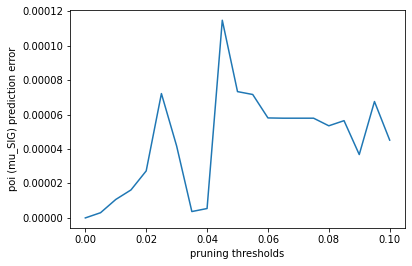

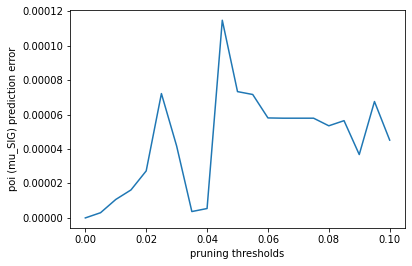

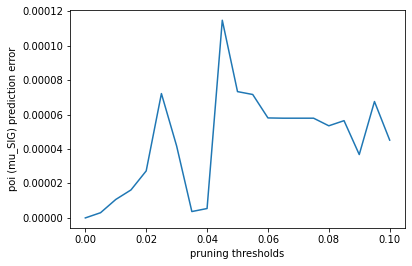

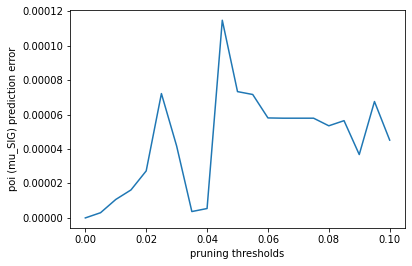

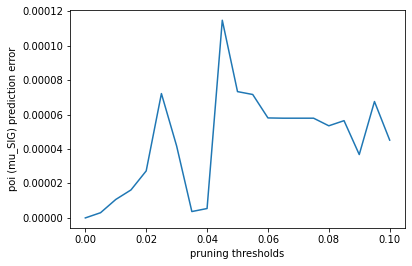

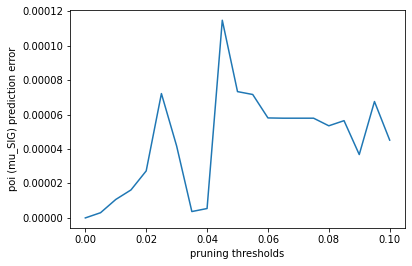

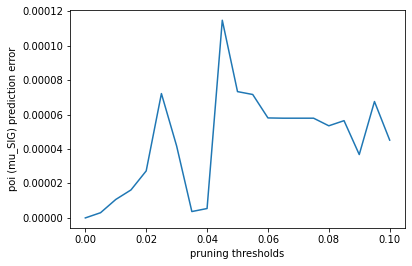

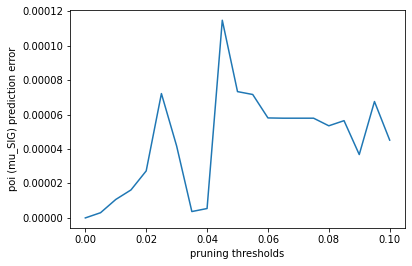

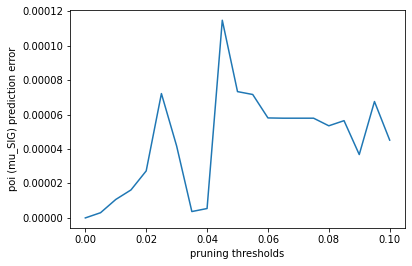

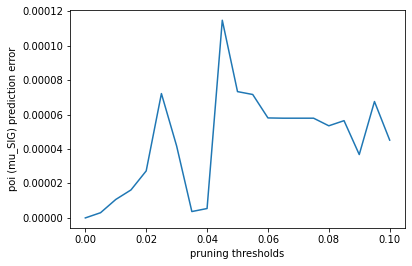

In [26]:
for k in range(num_executions):
    plt.plot(pruning_thresholds, poi_differences_all_exec[k])
    plt.xlabel("pruning thresholds")
    plt.ylabel("poi (" + poi_name + ") prediction error")
    plt.savefig(path + filename[:-5:] + "_execution_" + str(k) + ".jpg")
    plt.show()

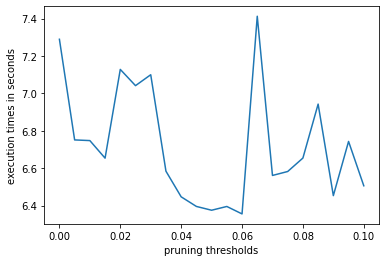

In [35]:
plt.plot(pruning_thresholds, average_exec_times)
plt.xlabel("pruning thresholds")
plt.ylabel("execution times in seconds")
plt.savefig("average_execution_times.jpg")
plt.show()

In [40]:
def model_complexity (workspace):
    num_modifiers = 0
    
    channels = workspace.get("channels")

    for channel in channels:
        samples = channel.get("samples")

        for sample in samples:
            num_mods_in_sample = len(sample.get("modifiers"))
            #print(num_mods_in_sample)
            num_modifiers += num_mods_in_sample
            #print(num_modifiers)
    
    return num_modifiers

In [42]:
complexities_all_specs = []

for workspace in pruned_workspaces_specs:
    m = model_complexity(workspace)
    complexities_all_specs.append(m)

In [43]:
complexities_all_specs

[1436,
 1302,
 1281,
 1274,
 1264,
 1258,
 1253,
 1242,
 1238,
 1234,
 1231,
 1230,
 1226,
 1224,
 1224,
 1224,
 1223,
 1221,
 1218,
 1216,
 1214]

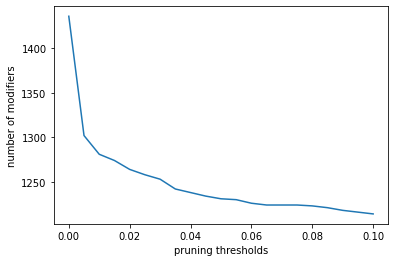

In [46]:
plt.plot(pruning_thresholds, complexities_all_specs)
plt.xlabel("pruning thresholds")
plt.ylabel("number of modifiers")
plt.savefig("model_complexities_modifier_amount.jpg")
plt.show()